In [43]:
data = data[['Date', 'Close', 'Low', 'High', 'Volume']]
data

,Date,Close,Low,High,Volume
0,1997-05-15,0.097917,0.096354,0.125000,1443120000
1,1997-05-16,0.086458,0.085417,0.098958,294000000
2,1997-05-19,0.085417,0.081250,0.088542,122136000
3,1997-05-20,0.081771,0.081771,0.087500,109344000
4,1997-05-21,0.071354,0.068750,0.082292,377064000
...,...,...,...,...,...
6511,2023-03-30,102.000000,101.010002,103.040001,53633400
6512,2023-03-31,103.290001,101.949997,103.489998,56704300
6513,2023-04-03,102.410004,101.430000,103.290001,41135700
6514,2023-04-04,103.949997,102.110001,104.199997,48662500


In [44]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

CLOSE_IND = 0
LOW_IND = 1
HIGH_IND = 2
VOLUME_IND = 3

OUT_VALUE = CLOSE_IND

data = pd.read_csv('AMZN.csv')

data

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000
...,...,...,...,...,...,...,...
6511,2023-03-30,101.550003,103.040001,101.010002,102.000000,102.000000,53633400
6512,2023-03-31,102.160004,103.489998,101.949997,103.290001,103.290001,56704300
6513,2023-04-03,102.300003,103.290001,101.430000,102.410004,102.410004,41135700
6514,2023-04-04,102.750000,104.199997,102.110001,103.949997,103.949997,48662500


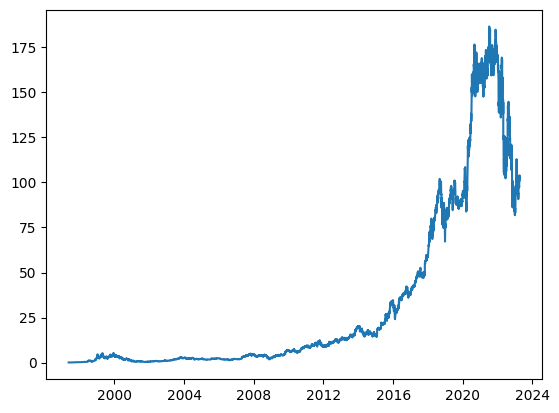

In [152]:
data['Date'] = pd.to_datetime(data['Date'])

plt.plot(data['Date'], data['Close'])

In [164]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    df.dropna(inplace=True)
        
    df1 = dc(df[['Date', 'Close']])
    df2 = dc(df[['Date', 'Low']])
    df3 = dc(df[['Date', 'High']])
    df4 = dc(df[['Date', 'Volume']])
    
    df1.set_index('Date', inplace=True)
    df2.set_index('Date', inplace=True)
    df3.set_index('Date', inplace=True)
    df4.set_index('Date', inplace=True)
    
    for i in range(1, n_steps+1):
        df1[f'Close(t-{i})'] = df1['Close'].shift(i)
        df2[f'Low(t-{i})'] = df2['Low'].shift(i)
        df3[f'High(t-{i})'] = df3['High'].shift(i)
        df4[f'Volume(t-{i})'] = df4['Volume'].shift(i)
        
    df1.dropna(inplace=True)
    df2.dropna(inplace=True)
    df3.dropna(inplace=True)
    df4.dropna(inplace=True)
    
    return df1, df2, df3, df4

lookback = 7
df1, df2, df3, df4 = prepare_dataframe_for_lstm(data, lookback)
df1



,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1997-05-27,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-28,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
1997-05-29,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
1997-05-30,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-06-02,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354
...,...,...,...,...,...,...,...,...
2023-03-30,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997,100.610001
2023-03-31,103.290001,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997
2023-04-03,102.410004,103.290001,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999


In [165]:
df1_np = df1.to_numpy()
df2_np = df2.to_numpy()
df3_np = df3.to_numpy()
df4_np = df4.to_numpy()

df1_np

array([[7.91670000e-02, 7.50000000e-02, 6.97920000e-02, ...,
        8.54170000e-02, 8.64580000e-02, 9.79170000e-02],
       [7.65630000e-02, 7.91670000e-02, 7.50000000e-02, ...,
        8.17710000e-02, 8.54170000e-02, 8.64580000e-02],
       [7.52600000e-02, 7.65630000e-02, 7.91670000e-02, ...,
        7.13540000e-02, 8.17710000e-02, 8.54170000e-02],
       ...,
       [1.02410004e+02, 1.03290001e+02, 1.02000000e+02, ...,
        9.80400010e+01, 9.81299970e+01, 9.87099990e+01],
       [1.03949997e+02, 1.02410004e+02, 1.03290001e+02, ...,
        9.72399980e+01, 9.80400010e+01, 9.81299970e+01],
       [1.01099998e+02, 1.03949997e+02, 1.02410004e+02, ...,
        1.00250000e+02, 9.72399980e+01, 9.80400010e+01]])

In [216]:
from sklearn.preprocessing import MinMaxScaler

scaler = [MinMaxScaler(feature_range=(-1, 1))]*4
df1_np_scaled = scaler[CLOSE_IND].fit_transform(df1_np)
df2_np_scaled = scaler[LOW_IND].fit_transform(df2_np)
df3_np_scaled = scaler[HIGH_IND].fit_transform(df3_np)
df4_np_scaled = scaler[VOLUME_IND].fit_transform(df4_np)

df1_np_scaled[5000:-1]

array([[-0.52093033, -0.51910725, -0.51320067, ..., -0.52539366,
        -0.5308628 , -0.53194592],
       [-0.51441019, -0.52093033, -0.51909877, ..., -0.52272879,
        -0.52539366, -0.5308628 ],
       [-0.51691959, -0.51441019, -0.52092184, ..., -0.51451436,
        -0.52272879, -0.52539366],
       ...,
       [ 0.10690997,  0.09307615,  0.07431453, ...,  0.05158   ,
         0.05779984,  0.05769258],
       [ 0.09747299,  0.10690997,  0.09308121, ...,  0.0506149 ,
         0.05158   ,  0.05779984],
       [ 0.11398769,  0.09747299,  0.10691495, ...,  0.04203581,
         0.0506149 ,  0.05158   ]])

In [217]:
# X = np.array([df1_np[:, 1:], df2_np[:, 1:], df3_np[:, 1:], df4_np[:, 1:]])
# y = np.array([df1_np[:, 0], df2_np[:, 0], df3_np[:, 0], df4_np[:, 0]])

X = np.zeros((len(df1_np), 4 * lookback))
y = np.zeros((len(df1_np), 4))
for i in range(0,len(df1_np)):
    X[i] = np.hstack((df1_np_scaled[i,1:], df2_np_scaled[i,1:], df3_np_scaled[i,1:], df4_np_scaled[i,1:]))
    y[i] = np.hstack((df1_np_scaled[i,0], df2_np_scaled[i,0], df3_np_scaled[i,0], df4_np_scaled[i,0]))

X.shape, y.shape

((6509, 28), (6509, 4))

In [218]:
X = dc(np.flip(X, axis=1)) #flip left right
X

array([[ 0.38034321, -0.72626105, -0.89176634, ..., -0.99998325,
        -1.        , -0.99995531],
       [-0.72626105, -0.89176634, -0.90408505, ..., -1.        ,
        -0.99994415, -0.99991063],
       [-0.89176634, -0.90408505, -0.6462703 , ..., -0.99994415,
        -0.99989946, -0.99993855],
       ...,
       [-0.9539538 , -0.95536353, -0.96439081, ...,  0.07431453,
         0.09308121,  0.10690997],
       [-0.95536353, -0.96439081, -0.97209597, ...,  0.09308121,
         0.10691495,  0.09747299],
       [-0.96439081, -0.97209597, -0.96144209, ...,  0.10691495,
         0.09747802,  0.11398769]])

In [219]:
split_index = int(len(X) * 0.95)

split_index

6183

In [220]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6183, 28), (326, 28), (6183, 4), (326, 4))

In [221]:
X_train = X_train.reshape((-1, lookback*4, 1))
X_test = X_test.reshape((-1, lookback*4, 1))

y_train = y_train.reshape((-1, 4))
y_test = y_test.reshape((-1, 4))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6183, 28, 1), (326, 28, 1), (6183, 4), (326, 4))

In [222]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([6183, 28, 1]),
 torch.Size([326, 28, 1]),
 torch.Size([6183, 4]),
 torch.Size([326, 4]))

In [223]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [224]:
train_dataset

In [225]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [226]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 28, 1]) torch.Size([16, 4])


In [227]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 4)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=4, bias=True)
)

In [228]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [229]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [230]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.636
Batch 200, Loss: 0.201
Batch 300, Loss: 0.056

Val Loss: 0.136
***************************************************

Epoch: 2
Batch 100, Loss: 0.028
Batch 200, Loss: 0.021
Batch 300, Loss: 0.013

Val Loss: 0.010
***************************************************

Epoch: 3
Batch 100, Loss: 0.006
Batch 200, Loss: 0.006
Batch 300, Loss: 0.006

Val Loss: 0.005
***************************************************

Epoch: 4
Batch 100, Loss: 0.005
Batch 200, Loss: 0.005
Batch 300, Loss: 0.004

Val Loss: 0.005
***************************************************

Epoch: 5
Batch 100, Loss: 0.005
Batch 200, Loss: 0.005
Batch 300, Loss: 0.005

Val Loss: 0.004
***************************************************

Epoch: 6
Batch 100, Loss: 0.004
Batch 200, Loss: 0.004
Batch 300, Loss: 0.005
Val Loss: 0.003
***************************************************

Epoch: 7
Batch 100, Loss: 0.004
Batch 200, Loss: 0.005
Batch 300, Loss: 0.004

Val Loss: 0.003
******************

(6183, 4)


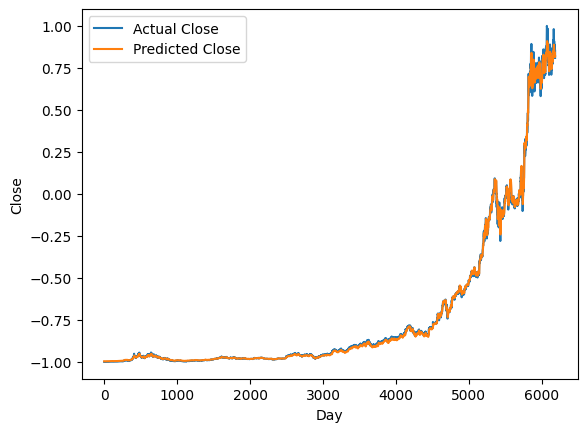

In [231]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

print(predicted.shape)

plt.plot(y_train[:,OUT_VALUE], label='Actual Close')
plt.plot(predicted[:,OUT_VALUE], label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [232]:
X_train.shape

torch.Size([6183, 28, 1])

# Translate back to real prices

In [233]:
train_predictions = predicted[:,OUT_VALUE].flatten()
print(train_predictions.shape, X_train.shape)

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions

dummies = scaler[OUT_VALUE].inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

(6183,) torch.Size([6183, 28, 1])


array([1.38417975e+07, 1.38826480e+07, 1.38005757e+07, ...,
       1.90460369e+09, 1.89471267e+09, 1.89995243e+09])

In [236]:
X_train.shape, y_train.shape

(torch.Size([6183, 28, 1]), torch.Size([6183, 4]))

In [237]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train[:, OUT_VALUE].flatten()
dummies = scaler[OUT_VALUE].inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([9.83678009e+06, 9.80781339e+06, 9.79326815e+06, ...,
       1.89193985e+09, 1.93897224e+09, 1.88948437e+09])

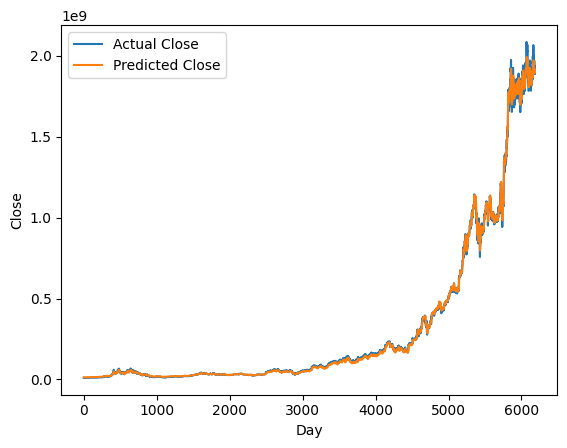

In [238]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [239]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy()
test_predictions = test_predictions[:,OUT_VALUE].flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler[OUT_VALUE].inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([1.89287923e+09, 1.89017901e+09, 1.88081534e+09, 1.88339833e+09,
       1.88836699e+09, 1.89198423e+09, 1.89015166e+09, 1.89132369e+09,
       1.88813921e+09, 1.88399227e+09, 1.87532900e+09, 1.87973231e+09,
       1.87600402e+09, 1.86338197e+09, 1.85048411e+09, 1.83963299e+09,
       1.82927443e+09, 1.83473093e+09, 1.84009324e+09, 1.83175442e+09,
       1.82744296e+09, 1.81466283e+09, 1.79622070e+09, 1.76691618e+09,
       1.71332754e+09, 1.68056955e+09, 1.64381043e+09, 1.61491751e+09,
       1.59978811e+09, 1.61091800e+09, 1.64411335e+09, 1.67539899e+09,
       1.69562022e+09, 1.66557098e+09, 1.70097869e+09, 1.73286867e+09,
       1.76730785e+09, 1.79030629e+09, 1.79694251e+09, 1.77964296e+09,
       1.76859352e+09, 1.76607057e+09, 1.77118753e+09, 1.76475234e+09,
       1.75259766e+09, 1.73516063e+09, 1.70241254e+09, 1.70194220e+09,
       1.71493104e+09, 1.72639511e+09, 1.72615230e+09, 1.72740201e+09,
       1.71306399e+09, 1.69146610e+09, 1.64486586e+09, 1.60348285e+09,
      

In [240]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test[:,OUT_VALUE].flatten()
dummies = scaler[OUT_VALUE].inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([1.90225163e+09, 1.86952879e+09, 1.90670049e+09, 1.91360472e+09,
       1.91395541e+09, 1.89837628e+09, 1.90941754e+09, 1.89315924e+09,
       1.88696204e+09, 1.86549759e+09, 1.90656117e+09, 1.87446204e+09,
       1.83921687e+09, 1.82693400e+09, 1.81913893e+09, 1.80724568e+09,
       1.85040848e+09, 1.84868242e+09, 1.80421687e+09, 1.81450636e+09,
       1.77864317e+09, 1.74948386e+09, 1.69790797e+09, 1.59741222e+09,
       1.61858155e+09, 1.56782404e+09, 1.55542428e+09, 1.56394321e+09,
       1.61227857e+09, 1.67458947e+09, 1.69262959e+09, 1.68615968e+09,
       1.55512369e+09, 1.76441155e+09, 1.76770781e+09, 1.80643839e+09,
       1.80394398e+09, 1.77960087e+09, 1.71601500e+09, 1.73687815e+09,
       1.75183914e+09, 1.76954515e+09, 1.73114862e+09, 1.70830893e+09,
       1.68153820e+09, 1.62173292e+09, 1.69446149e+09, 1.72152722e+09,
       1.71901615e+09, 1.69205608e+09, 1.70219541e+09, 1.65593683e+09,
       1.63079764e+09, 1.53961694e+09, 1.52359786e+09, 1.55995110e+09,
      

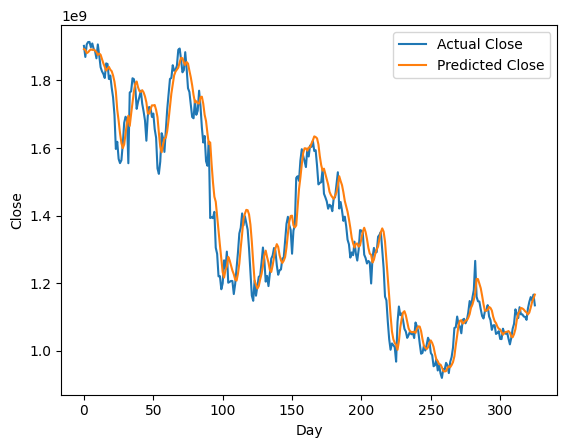

In [241]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [242]:
import math

MSE = np.square(np.subtract(new_y_test,test_predictions).mean()) 
 
RMSE = math.sqrt(MSE)
print("Root Mean Square Error: ", RMSE)

Root Mean Square Error:  20539126.84802848
